# Autoregressive Integrated Moving Average (ARIMA)

Since the data includes averages of audio features for each year, and there does not appear to be seasonality, ARIMA was chosen as the best option for a time series analysis. 

Following steps from https://builtin.com/data-science/time-series-forecasting-python
and https://medium.com/@evertongomede/forecasting-non-stationary-time-series-03b638a7cd50

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import seaborn.objects as so
import plotly.express as px 

In [4]:
df_year = pd.read_csv('data/data_by_year.csv')
df_year.head()

,mode,year,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,1921,0.886896,0.418597,260537.166667,0.231815,0.344878,0.205710,-17.048667,0.073662,101.531493,0.379327,0.653333,2
1,1,1922,0.938592,0.482042,165469.746479,0.237815,0.434195,0.240720,-19.275282,0.116655,100.884521,0.535549,0.140845,10
2,1,1923,0.957247,0.577341,177942.362162,0.262406,0.371733,0.227462,-14.129211,0.093949,114.010730,0.625492,5.389189,0
3,1,1924,0.940200,0.549894,191046.707627,0.344347,0.581701,0.235219,-14.231343,0.092089,120.689572,0.663725,0.661017,10
4,1,1925,0.962607,0.573863,184986.924460,0.278594,0.418297,0.237668,-14.146414,0.111918,115.521921,0.621929,2.604317,5


In [5]:
# only looking at post-1968

df_year_post = df_year.loc[df_year['year'] > 1968]
df_year_post.head(5)

,mode,year,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
48,1,1969,0.448846,0.488098,242545.9405,0.487625,0.159453,0.206966,-12.062166,0.054975,117.024329,0.554745,32.8440,2
49,1,1970,0.460057,0.506308,242852.1515,0.495633,0.127567,0.212269,-11.772558,0.051681,117.111610,0.572075,34.3945,2
50,1,1971,0.458336,0.504274,260511.7935,0.496361,0.125018,0.214915,-12.079936,0.059422,118.272247,0.574913,34.4475,2
51,1,1972,0.460043,0.520999,245914.2285,0.504526,0.114880,0.206955,-11.773563,0.054871,119.412852,0.595688,34.4850,2
52,1,1973,0.416524,0.515449,257002.7905,0.536138,0.099680,0.201375,-11.260197,0.057826,120.146316,0.592116,36.4280,0


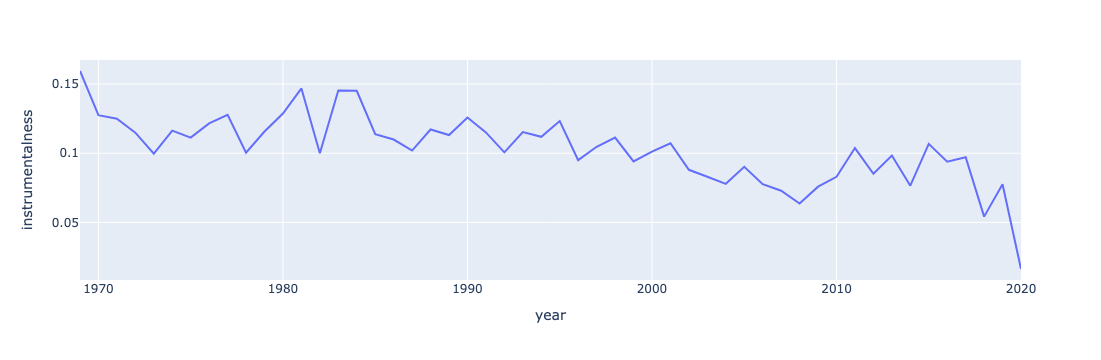

In [9]:
instrument = df_year_post[['year', 'instrumentalness']]

# Ensure the index is a datetime index
instrument.index = pd.to_datetime(instrument['year'], format='%Y')
instrument_copy = instrument.drop(columns = ['year']).copy()

fig = px.line(instrument_copy, x=instrument_copy.index, y=instrument_copy['instrumentalness'])
fig.show()

In [7]:
# testing for stationarity
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(instrument_copy['instrumentalness'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:', adf_test[4])

ADF Statistic: -1.036877
p-value: 0.739578
Critical Values: {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}


>The p-value higher than significance level of 0.5 indicates the data is not stationary. 

In [10]:
# Checking autocorrelation
autocorrelation_lag1 = instrument_copy['instrumentalness'].autocorr(lag=1)
print("One Year Lag: ", autocorrelation_lag1)

autocorrelation_lag2 = instrument_copy['instrumentalness'].autocorr(lag=2)
print("Two Year Lag: ", autocorrelation_lag2)

autocorrelation_lag3 = instrument_copy['instrumentalness'].autocorr(lag=3)
print("Three Year Lag: ", autocorrelation_lag3)

autocorrelation_lag10 = instrument_copy['instrumentalness'].autocorr(lag=10)
print("Ten Year Lag: ", autocorrelation_lag10)

autocorrelation_lag20 = instrument_copy['instrumentalness'].autocorr(lag=20)
print("Twenty Year Lag: ", autocorrelation_lag10)

One Year Lag:  0.6100942460244297
Two Year Lag:  0.6412100897965909
Three Year Lag:  0.4645797866098616
Ten Year Lag:  0.5238561840176388
Twenty Year Lag:  0.5238561840176388


>The highest correlation occurs with a 2-year lag.

In [11]:
# First-order Differencing to make the time series stationary
instrument_copy['Differenced_Data'] = instrument_copy['instrumentalness'] - (instrument_copy['instrumentalness'].shift(1))
instrument_copy = instrument_copy.dropna()
instrument_copy.head()

,instrumentalness,Differenced_Data
year,,
1970-01-01,0.127567,-0.031886
1971-01-01,0.125018,-0.002549
1972-01-01,0.114880,-0.010138
1973-01-01,0.099680,-0.015200
1974-01-01,0.116361,0.016681


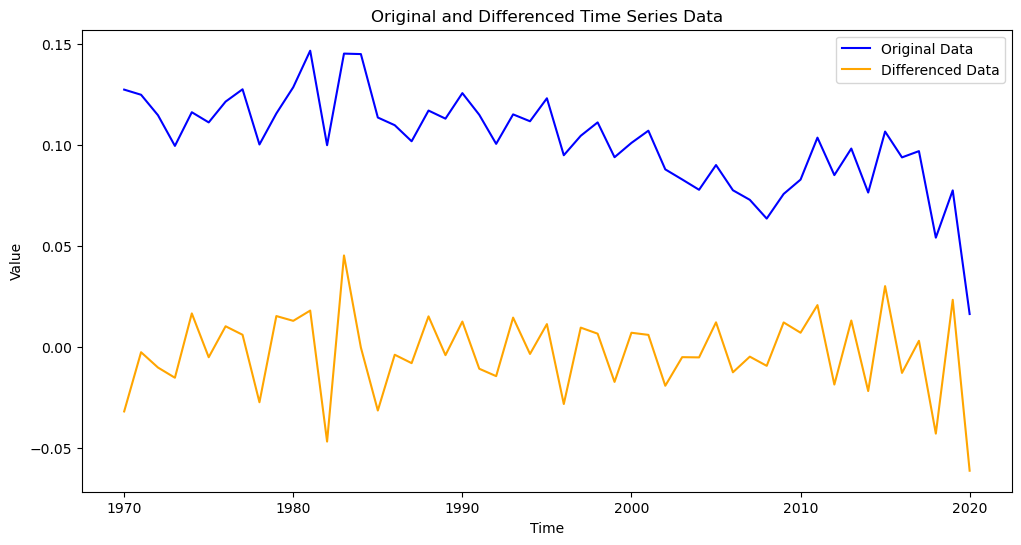

In [12]:
plt.figure(figsize=(12, 6))

# Plot the original data in blue
plt.plot(instrument_copy.index, instrument_copy['instrumentalness'], label='Original Data', color='blue')

# Plot the differenced time series data in orange
plt.plot(instrument_copy.index, instrument_copy['Differenced_Data'], label='Differenced Data', color='orange')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original and Differenced Time Series Data')
plt.legend()
plt.show()

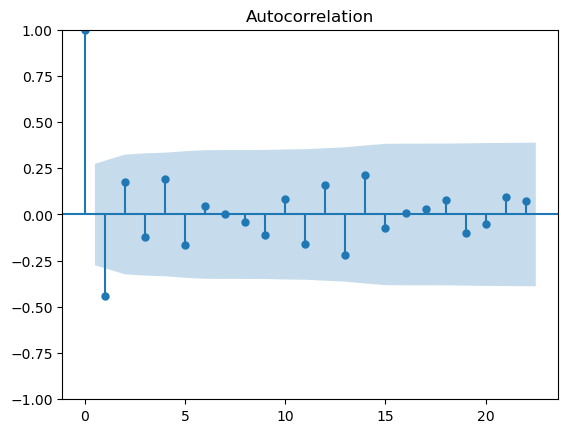

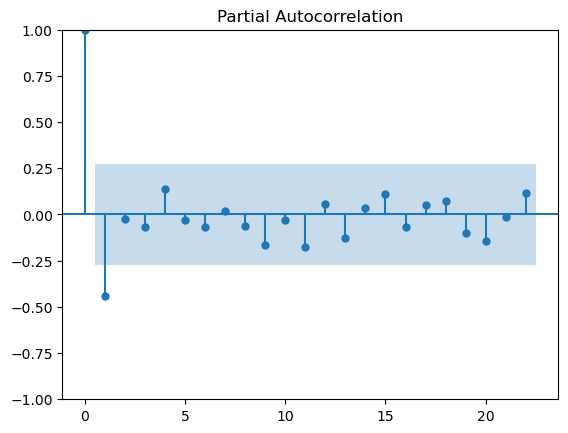

In [13]:
# ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(instrument_copy['Differenced_Data'], lags=22)
plot_pacf(instrument_copy['Differenced_Data'], lags=22)
plt.show()

/Users/Alli/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

/Users/Alli/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

/Users/Alli/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

/Users/Alli/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/Alli/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



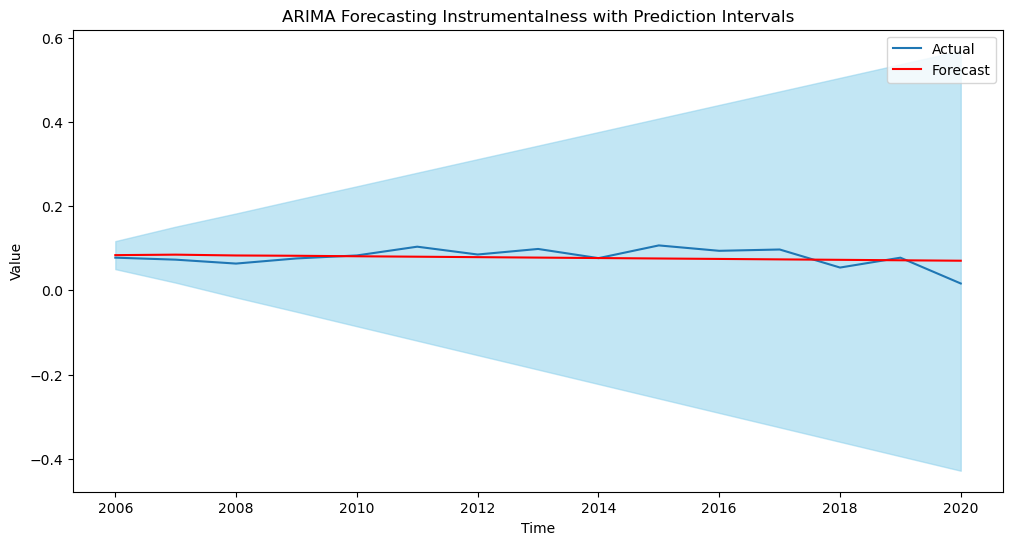

In [52]:
from statsmodels.tsa.arima.model import ARIMA

# Split the data into training and test sets
y = instrument_copy['Differenced_Data']
train_size = int(len(y) * 0.7)  # Example split, adjust as needed
train, test = y[:train_size], y[train_size:]

# Fit the ARIMA model
ARIMAmodel = ARIMA(train, order=(1, 1, 1)).fit()

# Forecast the test data
differenced_forecast = ARIMAmodel.forecast(steps=len(test))

# Calculate prediction intervals
residuals = ARIMAmodel.resid
sigma = np.std(residuals)
lower_bound_forecast = differenced_forecast - 1.96 * sigma
upper_bound_forecast = differenced_forecast + 1.96 * sigma

# Ensure the index length matches the test data length
index_test = instrument_copy.index[train_size:train_size + len(test)]

# Revert differenced forecasts to original scale
last_original_value = instrument_copy['instrumentalness'].iloc[train_size - 1]
original_forecast = last_original_value + differenced_forecast.cumsum()

# Convert prediction intervals to original scale
lower_bound = last_original_value + lower_bound_forecast.cumsum()
upper_bound = last_original_value + upper_bound_forecast.cumsum()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(index_test, instrument_copy['instrumentalness'][train_size:train_size + len(test)], label='Actual')  # Actual test values
plt.plot(index_test, original_forecast, label='Forecast', color='red')  # Forecasted original values
plt.fill_between(index_test, lower_bound, upper_bound, color='skyblue', alpha=0.5)  # Prediction intervals
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARIMA Forecasting Instrumentalness with Prediction Intervals')
plt.legend()
plt.show()


In [33]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(test,differenced_forecast))
print("RMSE: ", rms)

RMSE:  0.02432866702478526


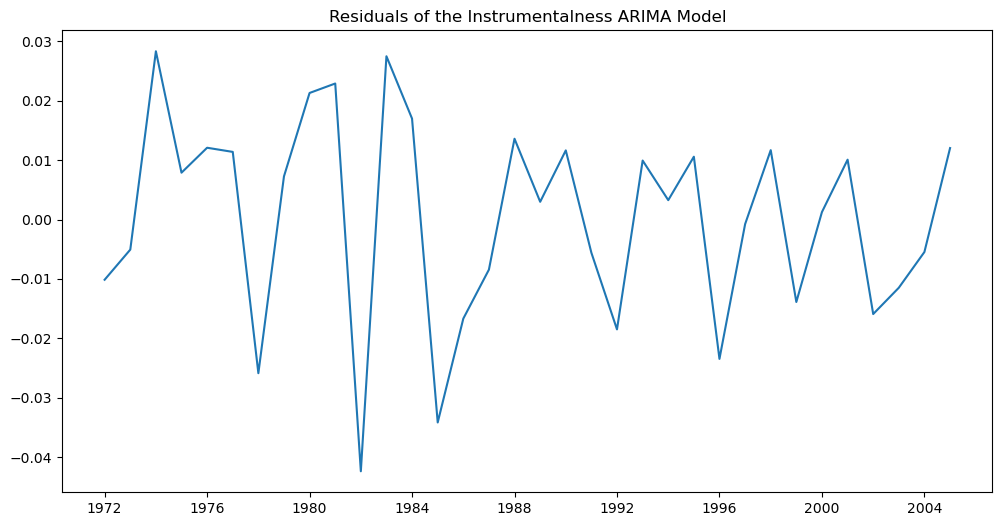

In [34]:
# Check residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals of the Instrumentalness ARIMA Model')
plt.show()

>ARIMA forecasting indicates instrumentalness will continue to be close to zero.

# ARIMA Analysis on Danceability

Duplicating the above steps for danceability. 

In [35]:
# just looking at danceability for now

df_year_post_dance = df_year_post[['year', 'danceability']]
df_year_post_dance.head()

,year,danceability
48,1969,0.488098
49,1970,0.506308
50,1971,0.504274
51,1972,0.520999
52,1973,0.515449


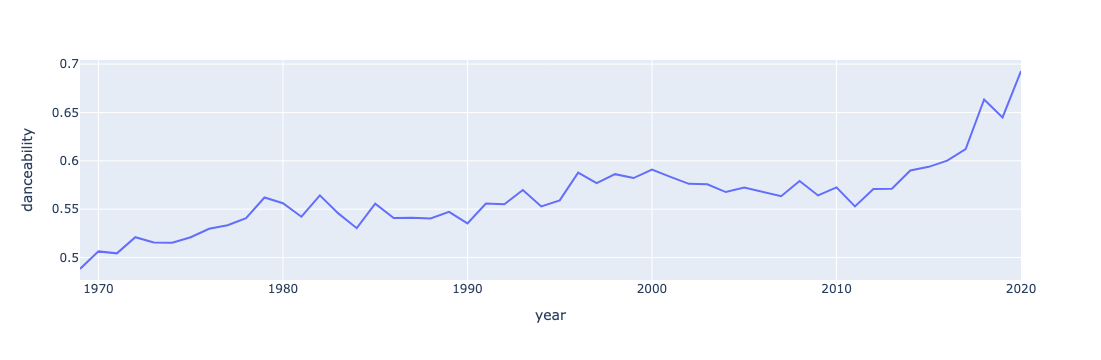

In [36]:
# Ensure the index is a datetime index
df_year_post_dance.index = pd.to_datetime(df_year_post_dance['year'], format='%Y')
dance_copy = df_year_post_dance.drop(columns = ['year']).copy()

fig = px.line(dance_copy, x=dance_copy.index, y=dance_copy['danceability'])
fig.show()

In [37]:
# testing for stationarity
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(dance_copy['danceability'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:', adf_test[4])

ADF Statistic: 1.191402
p-value: 0.995926
Critical Values: {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}


>The p-value is higher than a significance level of 0.05 so 'danceability' is clearly non-stationary

In [38]:
# Checking autocorrelation
autocorrelation_lag1 = dance_copy['danceability'].autocorr(lag=1)
print("One Year Lag: ", autocorrelation_lag1)

autocorrelation_lag5 = dance_copy['danceability'].autocorr(lag=5)
print("Five Year Lag: ", autocorrelation_lag5)

autocorrelation_lag10 = dance_copy['danceability'].autocorr(lag=10)
print("Ten Year Lag: ", autocorrelation_lag10)

autocorrelation_lag20 = dance_copy['danceability'].autocorr(lag=20)
print("Twenty Year Lag: ", autocorrelation_lag10)

One Year Lag:  0.900860604224388
Five Year Lag:  0.6263652597537213
Ten Year Lag:  0.4033859116767172
Twenty Year Lag:  0.4033859116767172


>Above, we see that correlation decreases the bigger our lag time between tests becomes, with the highest correlation year-to-year.

In [39]:
# Differencing to make the time series stationary
dance_copy['Differenced_Data'] = dance_copy['danceability'] - dance_copy['danceability'].shift(1)
dance_copy = dance_copy.dropna()
dance_copy.head()

,danceability,Differenced_Data
year,,
1970-01-01,0.506308,0.018210
1971-01-01,0.504274,-0.002034
1972-01-01,0.520999,0.016726
1973-01-01,0.515449,-0.005550
1974-01-01,0.515340,-0.000110


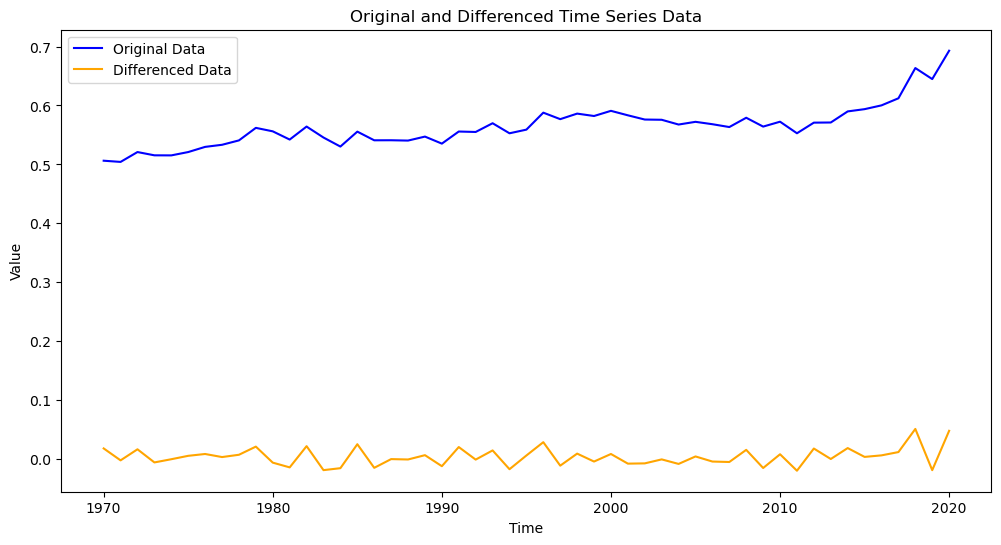

In [40]:
plt.figure(figsize=(12, 6))

# Plot the original data in blue
plt.plot(dance_copy.index, dance_copy['danceability'], label='Original Data', color='blue')

# Plot the differenced time series data in orange
plt.plot(dance_copy.index, dance_copy['Differenced_Data'], label='Differenced Data', color='orange')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original and Differenced Time Series Data')
plt.legend()
plt.show()


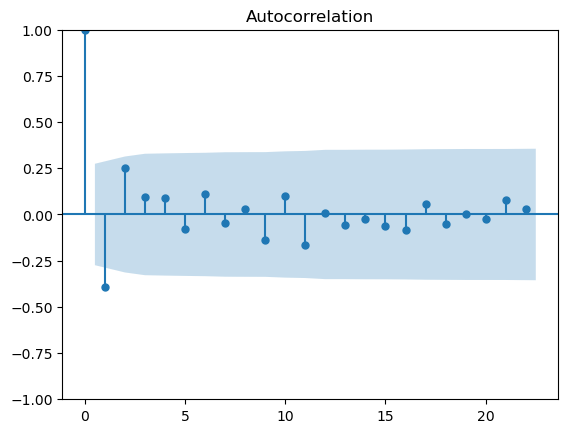

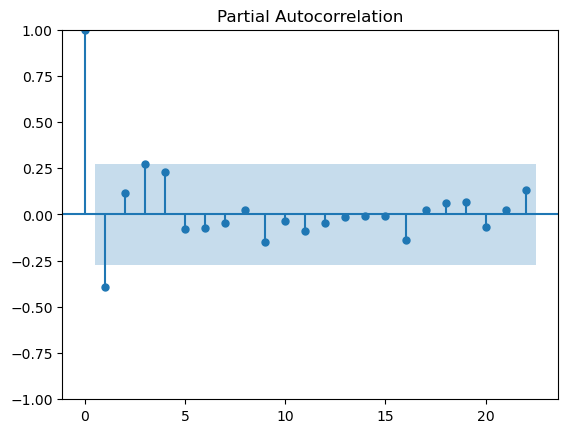

In [41]:
# ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(dance_copy['Differenced_Data'], lags=22)
plot_pacf(dance_copy['Differenced_Data'], lags=22)
plt.show()

>Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals.

/Users/Alli/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

/Users/Alli/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

/Users/Alli/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

/Users/Alli/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



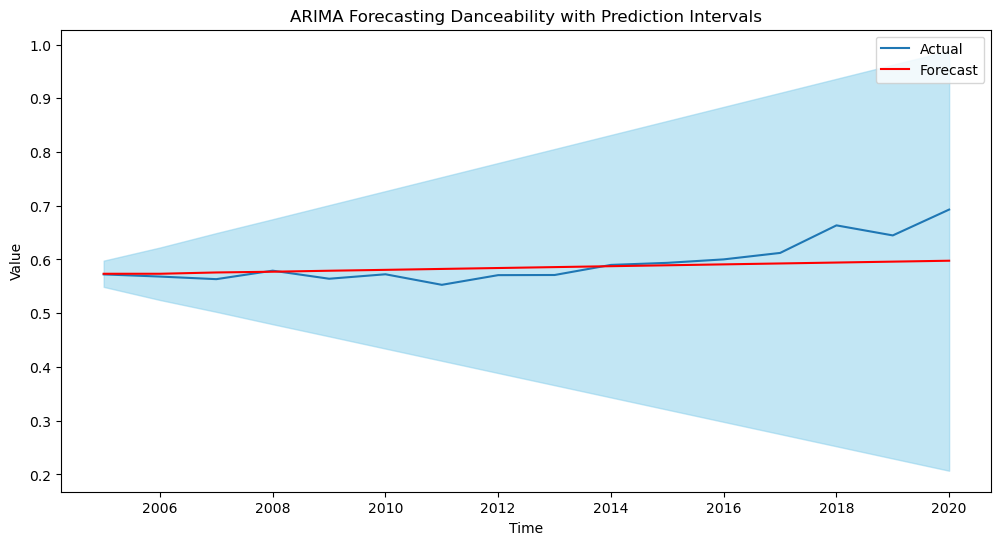

In [51]:
# Split the data into training and test sets
y = dance_copy['Differenced_Data']
train_size = int(len(y) * 0.7)  # Example split, adjust as needed
train, test = y[:train_size], y[train_size:]

# Fit the ARIMA model
ARIMAmodel = ARIMA(train, order=(1, 1, 1)).fit()

# Forecast the test data
differenced_forecast = ARIMAmodel.forecast(steps=len(test))

# Calculate prediction intervals
residuals = ARIMAmodel.resid
sigma = np.std(residuals)
lower_bound_forecast = differenced_forecast - 1.96 * sigma
upper_bound_forecast = differenced_forecast + 1.96 * sigma

# Ensure the index length matches the test data length
index_test = dance_copy.index[train_size:train_size + len(test)]

# Revert differenced forecasts to original scale
last_original_value = dance_copy['danceability'].iloc[train_size - 1]
original_forecast = last_original_value + differenced_forecast.cumsum()

# Convert prediction intervals to original scale
lower_bound = last_original_value + lower_bound_forecast.cumsum()
upper_bound = last_original_value + upper_bound_forecast.cumsum()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(index_test, dance_copy['danceability'][train_size:train_size + len(test)], label='Actual')  # Actual test values
plt.plot(index_test, original_forecast, label='Forecast', color='red')  # Forecasted original values
plt.fill_between(index_test, lower_bound, upper_bound, color='skyblue', alpha=0.5)  # Prediction intervals
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARIMA Forecasting Danceability with Prediction Intervals')
plt.legend()
plt.show()